In [1]:
import numpy as np
import pandas as pd
import os
from pyspatialml import Raster
#from osgeo import gdal
import rasterio
from rasterio.merge import merge

import matplotlib as mpl 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import ConfusionMatrixDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
os.chdir(r'C:\Users\hdey\Downloads\HimFac\PCA_USGAC')

In [3]:
predictors = ["Elevation.tif", "Slope.tif", "Soil_Moisture.tif", "Precip91.tif", "DisRiv.tif","NDVI.tif", "DD.tif", "TWI_Fil2.tif", "PopDen.tif", 
                "BuildingHeight.tif", "Dis_Road.tif", "POV.tif", "NoHSD.tif", "Minority.tif", "Age65.tif", "Age5.tif" ]

In [4]:
stack = Raster(predictors)
print(stack.names)
print(stack.shape)

dict_keys(['Elevation', 'Slope', 'Soil_Moisture', 'Precip91', 'DisRiv', 'NDVI', 'DD', 'TWI_Fil2', 'PopDen', 'BuildingHeight', 'Dis_Road', 'POV', 'NoHSD', 'Minority', 'Age65', 'Age5'])
(8806, 12979)


## Load Samples

In [5]:
raw_data = pd.read_csv('Destroyed_FL_dmg19k.csv')
data = raw_data.drop(columns=['geometry'])
data.head(5)

,class,Elevation,Slope,Soil_Moisture,Precip91,DisRiv,NDVI,TWI_Fil2,DD,PopDen,BuildingHeight,Dis_Road,POV,Minority,NoHSD,Age65,Age5
0,0,0,0.002225,0,134.295761,0.000000,-0.506900,3.695495,4.989536,0.0,5,0.000828,0.0,0.0,0.0,0.0,0
1,0,11,0.364776,24,132.059341,3142.822510,0.610449,3.067967,1.333287,0.0,2,0.001995,0.0,0.0,0.0,0.0,0
2,0,9,0.209056,22,122.790253,1994.257080,0.256436,3.748312,3.243583,0.0,3,0.002197,0.0,0.0,0.0,0.0,0
3,0,18,0.287196,19,107.747169,546.414978,0.662350,-0.854100,3.450593,0.0,1,0.003044,0.0,0.0,0.0,0.0,0
4,0,7,0.103189,14,99.007423,705.165649,-0.002193,0.327504,2.792220,0.0,3,0.003191,0.0,0.0,0.0,0.0,0


In [6]:
X = data.iloc[:, 1:17].to_numpy()
y = data['class'].to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (25447, 16)
y_train shape (25447,)
X_test shape (10907, 16)
y_test shape (10907,)


In [9]:
rf = RandomForestClassifier(max_depth=15, n_estimators=500, min_samples_split = 5, random_state=42)

In [10]:
# 6. Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=500,
                       random_state=42)

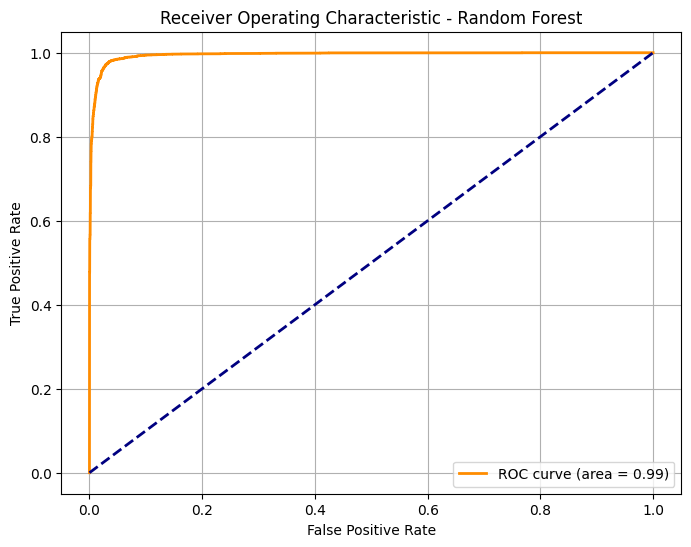

In [11]:
# Get predicted probabilities for the positive class
y_scores = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [15]:
probs = rf.predict_proba(X_test)

In [16]:
import numpy as np

def binary_shannon_entropy(prob_flood, eps=1e-15):
    """
    Compute Shannon entropy for binary classification probabilities.
    prob_flood: array-like of predicted probability for the 'flood' class (class 1)
    Returns: entropy value per sample
    """
    prob_flood = np.clip(prob_flood, eps, 1 - eps)  # avoid log(0)
    prob_no_flood = 1 - prob_flood
    return - (prob_flood * np.log(prob_flood) + prob_no_flood * np.log(prob_no_flood))


In [17]:
entropy = binary_shannon_entropy(probs[:, 1])  # flood class probability


In [18]:
total = len(entropy)
low_entropy = np.sum(entropy < 0.2)
moderate_entropy = np.sum((entropy >= 0.2) & (entropy < 0.5))
high_entropy = np.sum(entropy >= 0.5)

# Percentages
low_pct = 100 * low_entropy / total
moderate_pct = 100 * moderate_entropy / total
high_pct = 100 * high_entropy / total

print("Shannon Entropy-based Uncertainty (Binary Classification):")
print(f"  Low Entropy (< 0.2): {low_entropy} samples ({low_pct:.2f}%)")
print(f"  Moderate Entropy (0.2–0.5): {moderate_entropy} samples ({moderate_pct:.2f}%)")
print(f"  High Entropy (≥ 0.5): {high_entropy} samples ({high_pct:.2f}%)")


Shannon Entropy-based Uncertainty (Binary Classification):
  Low Entropy (< 0.2): 7453 samples (68.33%)
  Moderate Entropy (0.2–0.5): 2469 samples (22.64%)
  High Entropy (≥ 0.5): 985 samples (9.03%)


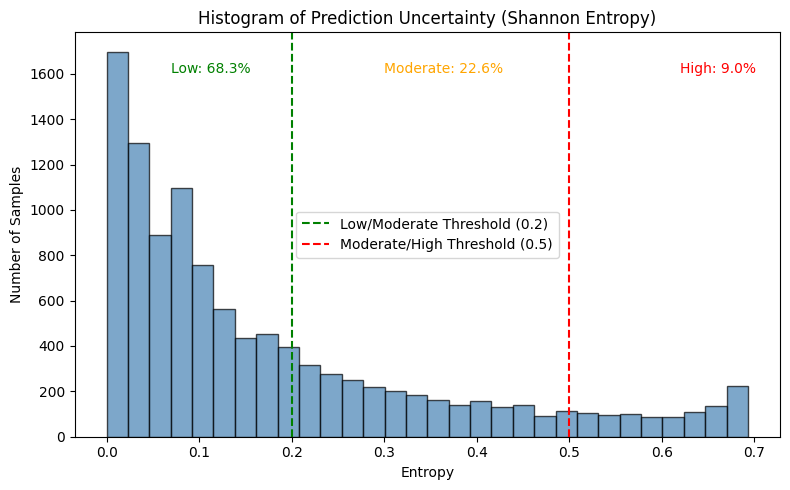

In [19]:
# --- Step 4: Plot histogram of uncertainty ---
plt.figure(figsize=(8, 5))
plt.hist(entropy, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(0.2, color='green', linestyle='--', label='Low/Moderate Threshold (0.2)')
plt.axvline(0.5, color='red', linestyle='--', label='Moderate/High Threshold (0.5)')

# Annotate percentages on the plot
plt.text(0.07, plt.ylim()[1]*0.9, f"Low: {low_pct:.1f}%", color='green')
plt.text(0.30, plt.ylim()[1]*0.9, f"Moderate: {moderate_pct:.1f}%", color='orange')
plt.text(0.62, plt.ylim()[1]*0.9, f"High: {high_pct:.1f}%", color='red')

plt.title("Histogram of Prediction Uncertainty (Shannon Entropy)")
plt.xlabel("Entropy")
plt.ylabel("Number of Samples")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
| Entropy Value                  | Interpretation | Meaning            |
| ------------------------------ | -------------- | ------------------ |
| Close to 0                     | Very confident | e.g., 0.99 vs 0.01 |
| Around 0.5                     | Most uncertain | e.g., 0.5 vs 0.5   |
| Close to 0.69 (max for binary) | Totally unsure | pure guess         |


In [ ]:
FRM_RF_USGAC_DestroyedTWI

Entropy map saved to: flood_entropy_map_GFD2.tif


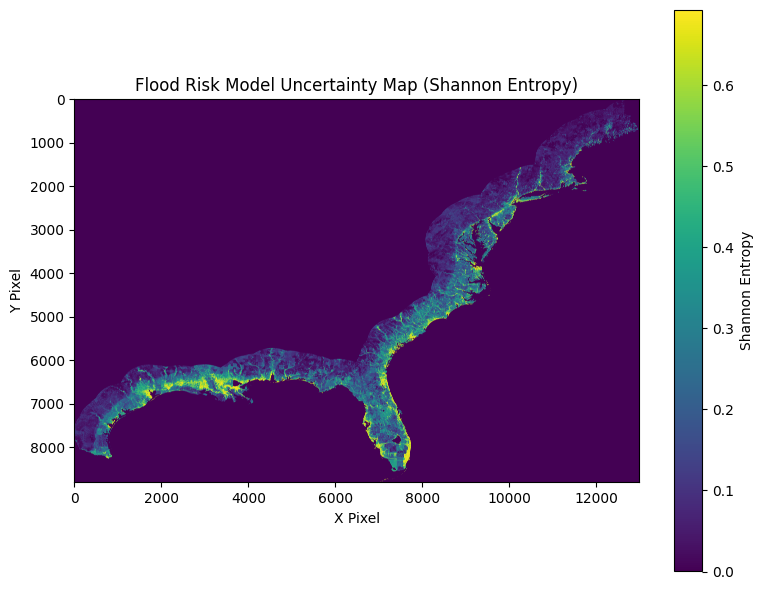

In [24]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# --- Step 1: Define Shannon entropy for binary probs ---
def binary_shannon_entropy(prob_flood, eps=1e-15):
    prob_flood = np.clip(prob_flood, eps, 1 - eps)
    prob_no_flood = 1 - prob_flood
    return - (prob_flood * np.log(prob_flood) + prob_no_flood * np.log(prob_no_flood))

# --- Step 2: Load probability raster ---
input_raster_path = 'FRM_RF_USGAC_General_TWI.tif'  # change to your file path
with rasterio.open(input_raster_path) as src:
    prob_data = src.read(1)  # Read flood probabilities (2D array)
    profile = src.profile     # Save metadata to write output later

# --- Step 3: Compute entropy ---
entropy_data = binary_shannon_entropy(prob_data)

# --- Step 4: Save entropy as new raster ---
output_raster_path = 'flood_entropy_map_GFD2.tif'
profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(output_raster_path, 'w', **profile) as dst:
    dst.write(entropy_data.astype(np.float32), 1)

print(f"Entropy map saved to: {output_raster_path}")

# --- Step 5: Plot entropy map ---
plt.figure(figsize=(8, 6))
plt.imshow(entropy_data, cmap='viridis')
plt.colorbar(label='Shannon Entropy')
plt.title('Flood Risk Model Uncertainty Map (Shannon Entropy)')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.tight_layout()
plt.show()


Probability raster summary:
Min: -3.4028234663852886e+38
Max: 0.992298424243927
Mean: -inf


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


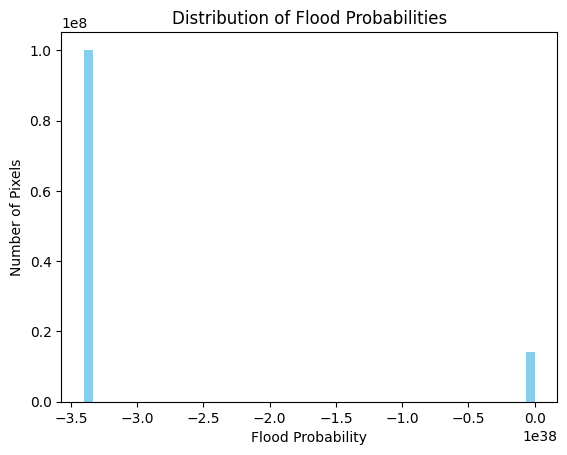

In [25]:
print("Probability raster summary:")
print(f"Min: {np.min(prob_data)}")
print(f"Max: {np.max(prob_data)}")
print(f"Mean: {np.mean(prob_data)}")

# Optional: histogram of raw probabilities
plt.hist(prob_data.flatten(), bins=50, color='skyblue')
plt.title('Distribution of Flood Probabilities')
plt.xlabel('Flood Probability')
plt.ylabel('Number of Pixels')
plt.show()


In [28]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# --- Step 1: Define Shannon entropy for binary probs ---
def binary_shannon_entropy(prob_flood, eps=1e-15):
    prob_flood = np.clip(prob_flood, eps, 1 - eps)
    prob_no_flood = 1 - prob_flood
    return - (prob_flood * np.log(prob_flood) + prob_no_flood * np.log(prob_no_flood))

# --- Step 2: Load and mask raster ---
input_raster_path = 'FRM_RF_USGAC_DestroyedTWI.tif'
with rasterio.open(input_raster_path) as src:
    prob_data = src.read(1)
    profile = src.profile
    nodata_val = src.nodata

    # Mask NoData values
    if nodata_val is not None:
        mask = prob_data == nodata_val
    else:
        # Handle typical invalid placeholder (float32 min)
        mask = prob_data < -1e+30

    prob_data = np.ma.array(prob_data, mask=mask)

# --- Step 3: Compute entropy ---
entropy_data = binary_shannon_entropy(prob_data)

# --- Step 4: Save entropy as new raster ---
output_raster_path = 'flood_entropy_map_EFD2_fixed.tif'
profile.update(dtype=rasterio.float32, count=1, nodata=-9999)

with rasterio.open(output_raster_path, 'w', **profile) as dst:
    entropy_filled = entropy_data.filled(-9999)  # Replace masked with nodata
    dst.write(entropy_filled.astype(np.float32), 1)

print(f"Entropy map saved to: {output_raster_path}")




Entropy map saved to: flood_entropy_map_EFD2_fixed.tif


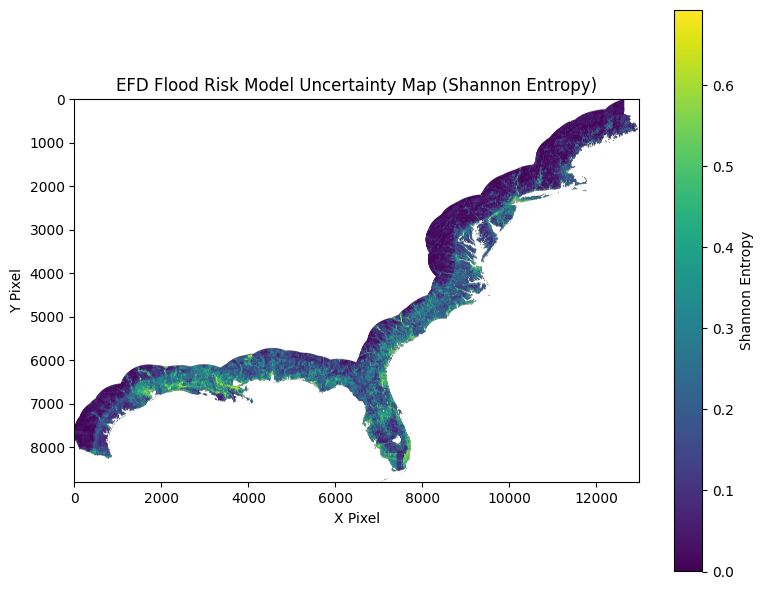

In [29]:
# --- Step 5: Plot valid values ---
plt.figure(figsize=(8, 6))
plt.imshow(np.ma.filled(entropy_data, np.nan), cmap='viridis')
plt.colorbar(label='Shannon Entropy')
plt.title('EFD Flood Risk Model Uncertainty Map (Shannon Entropy)')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.tight_layout()
plt.show()